# Task 2
## Task 2.1

In [217]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

In [218]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


In [219]:
# Spectral (or Fourier) layer in 1d

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [220]:
class FNO1d(nn.Module):
    def __init__(self, modes, width, dim=2):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(dim, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [221]:
torch.manual_seed(0)
np.random.seed(0)

In [222]:
n_train = 128
n_val = 32
n_test = 256

train = torch.from_numpy(np.load("data/data_train_128.npy")).type(torch.float32)
val = torch.from_numpy(np.load("data/data_val_128.npy")).type(torch.float32)
test = torch.from_numpy(np.load("data/data_test_128.npy")).type(torch.float32)

u0 = train[:, 0, :]
u1 = train[:, 4, :]

In [223]:
x_grid = np.linspace(0, 1, 128)
x_grid = torch.tensor(x_grid, dtype=torch.float32)
u0 = torch.tensor(u0, dtype=torch.float32)
u1 = torch.tensor(u1, dtype=torch.float32)

x_grid = x_grid.unsqueeze(0).repeat(u0.shape[0], 1)

input_tensor = torch.stack([u0, x_grid], dim=2)
output_tensor = u1

# Consider only first (t=0) and last (t=1) time values
u0_train = train[:, 0, :]
u1_train = train[:, 4, :]
u0_val   = val[:, 0, :]
u1_val   = val[:, 4, :]
u0_test  = test[:, 0, :]
u1_test  = test[:, 4, :]

s = u0_train.shape[1]
x = np.linspace(0, 1, s)
x = torch.tensor(x, dtype=torch.float32)

def build_input(u0, x):
    u0 = torch.tensor(u0, dtype=torch.float32)
    x_grid = x.unsqueeze(0).repeat(u0.shape[0], 1)
    return torch.stack([u0, x_grid], dim=2)

input_train = build_input(u0_train, x)
input_val   = build_input(u0_val, x)
input_test  = build_input(u0_test, x)

output_train = torch.tensor(u1_train, dtype=torch.float32)
output_val   = torch.tensor(u1_val, dtype=torch.float32)
output_test  = torch.tensor(u1_test, dtype=torch.float32)

batch_size = 10

training_set = DataLoader(TensorDataset(input_train, output_train), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(TensorDataset(input_val, output_val), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(input_test, output_test), batch_size=batch_size, shuffle=False)

/var/folders/cq/6lv3lnyd7l340pjp1d_14xj80000gn/T/ipykernel_18596/628680330.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0, dtype=torch.float32)
/var/folders/cq/6lv3lnyd7l340pjp1d_14xj80000gn/T/ipykernel_18596/628680330.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u1 = torch.tensor(u1, dtype=torch.float32)
/var/folders/cq/6lv3lnyd7l340pjp1d_14xj80000gn/T/ipykernel_18596/628680330.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0, dtype=torch.float32)
/var/folders/cq/6lv3lnyd7l340pjp1

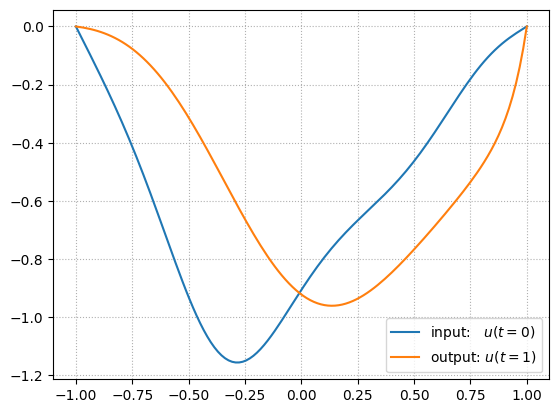

In [224]:
id_sample = 32

plt.plot(np.linspace(-1,1,input_train.shape[1]),input_train[id_sample,:,0], label = "input:   $u(t = 0)$")
plt.plot(np.linspace(-1,1,input_train.shape[1]),output_train[id_sample,:], label = "output: $u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

In [225]:
learning_rate = 0.001
epochs = 50 # = 10 # = 250
step_size = 50
gamma = 0.5
modes = 16
width = 64
fno = FNO1d(modes, width) # model

######### Epoch: 0  ######### Train Loss: 0.052025236928546166  ######### Relative L2 Test Norm: 2.730178796328031
######### Epoch: 1  ######### Train Loss: 0.0067500317270315965  ######### Relative L2 Test Norm: 1.7441138120797963
######### Epoch: 2  ######### Train Loss: 0.0016406259479145836  ######### Relative L2 Test Norm: 1.260105774952815
######### Epoch: 3  ######### Train Loss: 0.0009929763463447864  ######### Relative L2 Test Norm: 1.0327222530658429
######### Epoch: 4  ######### Train Loss: 0.0009361843274622585  ######### Relative L2 Test Norm: 2.0317174838139462
######### Epoch: 5  ######### Train Loss: 0.0016524285300989698  ######### Relative L2 Test Norm: 0.7672512164482703
######### Epoch: 6  ######### Train Loss: 0.0006033461610164981  ######### Relative L2 Test Norm: 0.6938899205281184
######### Epoch: 7  ######### Train Loss: 0.0006756916570418415  ######### Relative L2 Test Norm: 0.8450143520648663
######### Epoch: 8  ######### Train Loss: 0.0010683895963259963  ##

Text(0, 0.5, 'Train Loss')

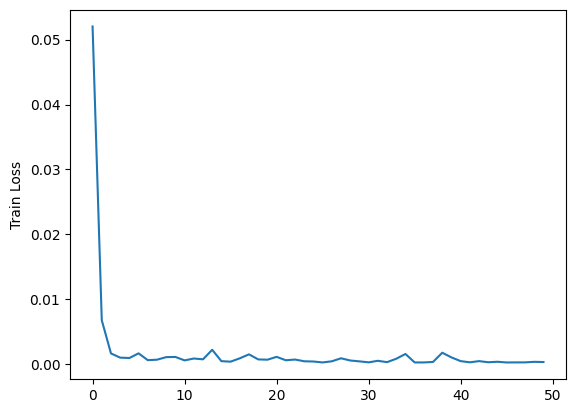

In [ ]:
history = []

optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)
    history.append(train_mse)

plt.grid(True, which="both", ls=":")
plt.plot(history)
plt.xscale("log")
plt.ylabel(r"$\mathrm{Train Loss}$")

In [227]:
rel_l2 = 0.0

with torch.no_grad():
    for input_batch, output_batch in testing_set:
        pred = fno(input_batch).squeeze(2)

        batch_error = torch.norm(pred - output_batch, dim=1) / \
                      torch.norm(output_batch, dim=1)

        rel_l2 += batch_error.sum().item()

rel_l2 /= 128
print("Average relative L2 error:", rel_l2)


Average relative L2 error: 0.04415191453881562


### Task 2.2

Resolution 32: Average Relative L2 Error = 2.0580e-01
Resolution 64: Average Relative L2 Error = 7.2618e-02
Resolution 96: Average Relative L2 Error = 5.3108e-02
Resolution 128: Average Relative L2 Error = 4.4152e-02


Text(0, 0.5, 'L2 Error')

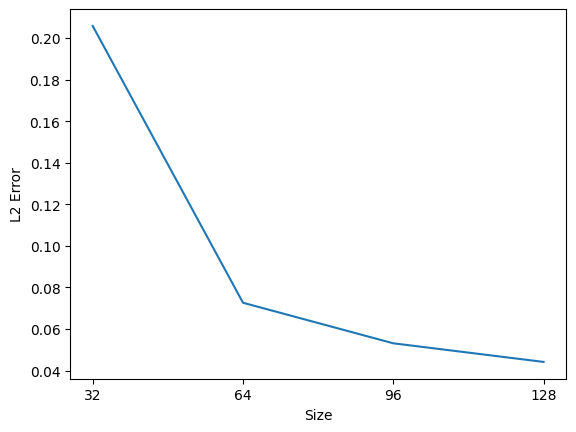

In [ ]:
size = [32, 64, 96, 128]
history = []

for s in size:
    data = np.load(f"data/data_test_{s}.npy")   # (128, 5, s)

    u0 = torch.tensor(data[:, 0, :], dtype=torch.float32)
    u1 = torch.tensor(data[:, 4, :], dtype=torch.float32)

    x = torch.linspace(0, 1, s)
    x = x.unsqueeze(0).repeat(u0.shape[0], 1)

    input_tensor = torch.stack([u0, x], dim=2)

    dataset = TensorDataset(input_tensor, u1) # Load dataset at time t = 1.0
    loader = DataLoader(dataset, batch_size=10, shuffle=False)

    rel_l2 = 0.0

    with torch.no_grad():
        for input_batch, output_batch in loader:
            pred = fno(input_batch).squeeze(2)
            batch_error = torch.norm(pred - output_batch, dim=1) / torch.norm(output_batch, dim=1)
            rel_l2 += batch_error.sum().item()

    rel_l2 /= u0.shape[0]

    print(f"Resolution {s}: Average Relative L2 Error = {rel_l2:.4e}")
    history.append(rel_l2)


plt.plot(size, history)
plt.xticks(size)
plt.xlabel(r"$\mathrm{Size}$")
plt.ylabel(r"$\mathrm{L2 Error}$")

### Task 2.3.1

In [229]:
data = np.load("data/data_train_128.npy")  # (1024, 5, 128)
times = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype=np.float32)

u0_all = []
x_all  = []
t_all  = []
u_all  = []

x_grid = torch.linspace(0, 1, 128)

for n in range(data.shape[0]):          # trajectories
    u0 = data[n, 0, :]                  # initial condition

    for k, t in enumerate(times):       # time snapshots
        u0_all.append(u0)
        x_all.append(x_grid)
        t_all.append(torch.full((128,), t))
        u_all.append(data[n, k, :])

u0_all = torch.tensor(np.stack(u0_all), dtype=torch.float32)
x_all  = torch.stack(x_all)
t_all  = torch.stack(t_all)
u_all  = torch.tensor(np.stack(u_all), dtype=torch.float32)

input_all = torch.stack([u0_all, x_all, t_all], dim=2)

In [ ]:
test_data = np.load("data/data_val_128.npy")   # (32, 5, 128)

u0_val_all = []
x_val_all  = []
t_val_all  = []
u_val_all  = []

x_grid = torch.linspace(0, 1, 128)

for n in range(test_data.shape[0]):
    u0 = test_data[n, 0, :]
    for k, t in enumerate(times):
        u0_val_all.append(u0)
        x_val_all.append(x_grid)
        t_val_all.append(torch.full((128,), t))
        u_val_all.append(test_data[n, k, :])

u0_val_all = torch.tensor(np.stack(u0_val_all), dtype=torch.float32)
x_val_all  = torch.stack(x_val_all)
t_val_all  = torch.stack(t_val_all)
u_val_all  = torch.tensor(np.stack(u_val_all), dtype=torch.float32)

input_val_all = torch.stack([u0_val_all, x_val_all, t_val_all], dim=2)

validation_set = DataLoader(
    TensorDataset(input_val_all, u_val_all),
    batch_size=10,
    shuffle=False
)

In [ ]:
history = []
training_set = DataLoader(
    TensorDataset(input_all, u_all),
    batch_size=10,
    shuffle=False
)
fno=FNO1d(modes, width, 3)
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)
    history.append(test_relative_l2)

plt.grid(True, which="both", ls=":")
plt.plot(epochs.shape[1], history)
plt.ylabel("L2 error Norm")
plt.xlabel("Epochs")

######### Epoch: 0  ######### Train Loss: 0.027772638798978733  ######### Relative L2 Test Norm: 41.82384931124174
######### Epoch: 1  ######### Train Loss: 0.009676896409132496  ######### Relative L2 Test Norm: 16.389174424684963
######### Epoch: 2  ######### Train Loss: 0.004090772588199343  ######### Relative L2 Test Norm: 19.074168865497295


KeyboardInterrupt: 

### Task 2.3.2

t = 0.00 | Average Relative L2 Error = 4.5808e-02
t = 0.25 | Average Relative L2 Error = 4.0276e-02
t = 0.50 | Average Relative L2 Error = 3.6738e-02
t = 0.75 | Average Relative L2 Error = 4.5786e-02
t = 1.00 | Average Relative L2 Error = 6.8335e-02


([<matplotlib.axis.XTick at 0x12f2d82e0>,
 [Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00')])

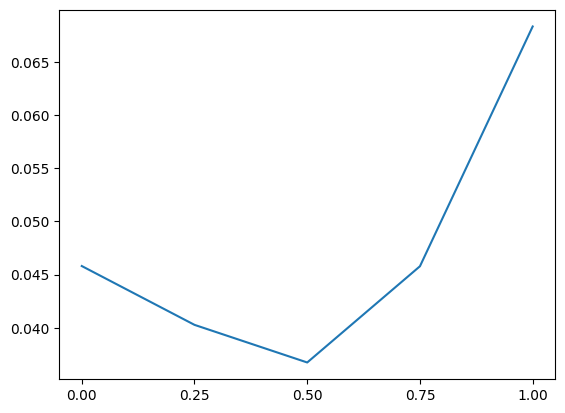

In [ ]:
test = np.load("data/data_test_128.npy")   # (128, 5, 128)
u0 = torch.tensor(test[:, 0, :], dtype=torch.float32)  # (128, 128)
history = []

x = torch.linspace(0, 1, 128)
x = x.unsqueeze(0).repeat(u0.shape[0], 1)
times = [0.0, 0.25, 0.5, 0.75, 1.0]
indices = [0, 1, 2, 3, 4]

fno.eval()

for t_val, idx in zip(times, indices):
    t = torch.full_like(x, t_val)  # (128, 128)
    u_true = torch.tensor(test[:, idx, :], dtype=torch.float32)

    input_test = torch.stack([u0, x, t], dim=2)

    # compute relative L2 error
    rel_l2 = 0.0

    with torch.no_grad():
        pred = fno(input_test).squeeze(2)  # (128, 128)

        rel_l2 = torch.norm(pred - u_true, dim=1) / \
                 torch.norm(u_true, dim=1)

    print(f"t = {t_val:.2f} | Average Relative L2 Error = {rel_l2.mean().item():.4e}")
    history.append(rel_l2.mean())


plt.grid(True, which="both", ls=":")
plt.plot(times, history)
plt.xticks(times)

**Task 2.4.1**

In [ ]:
test_unknown = np.load("data/data_test_unknown_128.npy")  # (128, 5, 128)

u0 = torch.tensor(test_unknown[:, 0, :], dtype=torch.float32)
u1 = torch.tensor(test_unknown[:, 4, :], dtype=torch.float32)

x = torch.linspace(0, 1, 128)
x = x.unsqueeze(0).repeat(u0.shape[0], 1)

t = torch.ones_like(x) * 1.0

input_test = torch.stack([u0, x, t], dim=2)

fno.eval()

with torch.no_grad():
    pred = fno(input_test).squeeze(2)
    rel_l2 = torch.norm(pred - u1, dim=1) / torch.norm(u1, dim=1)

print("Zero-shot relative L2 error:", rel_l2.mean().item())

Zero-shot relative L2 error: 0.17531830072402954


### Task 2.4.2

In [ ]:
finetune_train = np.load("data/data_finetune_train_unknown_128.npy")  # (32, 5, 128)
finetune_val   = np.load("data/data_finetune_val_unknown_128.npy")    # (8, 5, 128)

times = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype=np.float32)
x_grid = torch.linspace(0, 1, 128)

def build_all2all(data):
    inputs = []
    outputs = []

    for n in range(data.shape[0]):
        u0 = data[n, 0, :]

        for k, t in enumerate(times):
            x = x_grid
            t_vec = torch.full((128,), t)

            inp = torch.stack([
                torch.tensor(u0, dtype=torch.float32),
                x,
                t_vec
            ], dim=1)

            inputs.append(inp)
            outputs.append(torch.tensor(data[n, k, :], dtype=torch.float32))

    return torch.stack(inputs), torch.stack(outputs)


In [ ]:
input_ft_train, output_ft_train = build_all2all(finetune_train)
input_ft_val,   output_ft_val   = build_all2all(finetune_val)

In [ ]:
train_loader = DataLoader(
    TensorDataset(input_ft_train, output_ft_train),
    batch_size=5,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(input_ft_val, output_ft_val),
    batch_size=5,
    shuffle=False
)

loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    fno.train()
    train_loss = 0.0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = fno(x_batch).squeeze(2)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    fno.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            pred = fno(x_batch).squeeze(2)
            val_loss += loss_fn(pred, y_batch).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: train={train_loss:.4e}, val={val_loss:.4e}")


Epoch 0: train=1.2361e-03, val=1.7720e-03
Epoch 1: train=6.8002e-04, val=9.5088e-04
Epoch 2: train=4.3852e-04, val=9.5496e-04
Epoch 3: train=3.8652e-04, val=8.0800e-04
Epoch 4: train=3.0977e-04, val=7.0338e-04
Epoch 5: train=2.9454e-04, val=8.1237e-04


KeyboardInterrupt: 